In [1]:
%matplotlib inline

import os
import pickle
import statistics
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf

#from dopamine.colab import utils as colab_utils
import matplotlib.pyplot as plt

In [2]:
def load_experiment_data(algo_sources, key_factors):
    data = {}
    for algo, source in algo_sources.items():
        data[algo] = {}
        if source.exists() and source.is_dir():
            log_files = sorted(source.glob('[!.]*'))
            # print('{}: {} runs'.format(algo, len(log_files)) )
            for log_file in log_files:
                with tf.gfile.Open(str(log_file.absolute()), 'rb') as f:
                    unpickled = pickle.load(f)          
                exp = os.path.basename(log_file)
                data[algo][exp] = {}
                for factor in key_factors:
                    data[algo][exp][factor] = {}
                    data[algo][exp][factor]['avg'] = []
                    data[algo][exp][factor]['max'] = []
                    data[algo][exp][factor]['min'] = []
                    data[algo][exp][factor]['upper'] = []
                    data[algo][exp][factor]['lower'] = []
                    for era in range(len(unpickled)):
                        avg = round(statistics.mean(unpickled[era][factor]), 2)
                        data[algo][exp][factor]['avg'].append(
                            avg
                        )
                        data[algo][exp][factor]['max'].append(
                            max(unpickled[era][factor])
                        )
                        data[algo][exp][factor]['min'].append(
                            min(unpickled[era][factor])
                        )
                        if len(unpickled[era][factor]) > 1:
                            std = round(statistics.stdev(unpickled[era][factor]), 2)
                        else:
                            std = 0.0
                        data[algo][exp][factor]['upper'].append(
                            avg + std
                        )
                        data[algo][exp][factor]['lower'].append(
                            avg - std
                        )           
    return data

In [3]:
def plot_one_algo(data_df, algo, source, key_factors, params, eras=20):
    for factor in key_factors:
        fig = plt.figure(figsize=params['fig_size'])
        ax = plt.subplot(111)
        if source.exists() and source.is_dir():
            log_files = sorted(source.glob('[!.]*'))
            j = 0
            for log_file in log_files:
                exp = os.path.basename(log_file) 
                ax.plot(
                    data_df[algo][data_df[algo].notnull()][exp][factor]['avg'],
                    label=exp,
                    color=params['colors_rgb'][j],
                    marker=params['markers'][j]
                )
                j += 1
        ax.set_xlabel('Eras', fontsize=params['font_size'])
        ax.set_ylabel(factor, fontsize=params['font_size'])
        ax.set_ylim([-22, 22])
        ax.set_xlim([-1, eras + 1])
        ax.set_facecolor(params['background_color'])
        ax.grid()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 1, box.height])
        ax.legend(loc='best', prop={'size': params['font_size']})
        fig.suptitle('{} - {}'.format(algo, factor))
        plt.show()

def plot_summary(data_df, algo_info, key_factors, params, eras=20):
    for factor in key_factors:
        fig = plt.figure(figsize=params['fig_size'])
        ax = plt.subplot(111)
        j = 0
        for algo, source in algo_info.items():
            if source.exists() and source.is_dir():
                log_files = sorted(source.glob('[!.]*'))
                temp_data = []
                for log_file in log_files:
                    exp = os.path.basename(log_file)
                    temp_data.append(data_df[algo][data_df[algo].notnull()][exp][factor]['avg'])
                avg = np.mean(np.array(temp_data), axis=0)
                std = np.std(np.array(temp_data), axis=0)              
                ax.plot(avg, label=algo, color=params['colors_rgb'][j], marker=params['markers'][j])
                ax.plot(avg + std, label='', color=params['colors_rgb'][j], alpha=0.2)
                ax.fill_between(range(len(avg)), avg, avg + std, color=params['colors_rgb'][j], alpha=0.15)
                ax.plot(avg - std, label='', color=params['colors_rgb'][j], alpha=0.2)
                ax.fill_between(range(len(avg)), avg, avg - std, color=params['colors_rgb'][j], alpha=0.15)
                j += 1
        ax.set_xlabel('Eras', fontsize=params['font_size'])
        ax.set_ylabel(factor, fontsize=params['font_size'])
        ax.tick_params(axis='both', which='major', labelsize=params['font_size'])
        ax.set_ylim([-22, 22])
        ax.set_xlim([-1, eras + 1])
        ax.set_facecolor(params['background_color'])
        ax.grid()
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 1, box.height])
        #ax.legend(loc='center left', bbox_to_anchor=(0.0, 0.5))
        ax.legend(loc='best', prop={'size': params['font_size']})
        fig.suptitle('{}'.format(factor))
        plt.show()    
                
def plot_algos(algo_info, key_factors, only_summary=True, eras=20):
    params = {
        'colors_rgb' : [
            '#b00149', '#03719c', '#5ca904', '#ff9408', '#c83cb9',
            '#b00149', '#03719c', '#5ca904', '#ff9408', '#c83cb9'],
        'markers' : [
            'x', '|', 'o', 's', '*',
            '*', 'o', '|', 'x', 's'],
        'font_size' : 14,
        'fig_size': (12,6),
        'background_color': 'whitesmoke'  #'lightgrey'
    }
    
    data = load_experiment_data(algo_info, key_factors)
    data_df = pd.DataFrame.from_dict(data)

    #plot all runs
    if not only_summary:
        for algo, source in algo_info.items():
            plot_one_algo(data_df, algo, source, key_factors, params, eras)

    plot_summary(data_df, algo_info, key_factors, params, eras)             

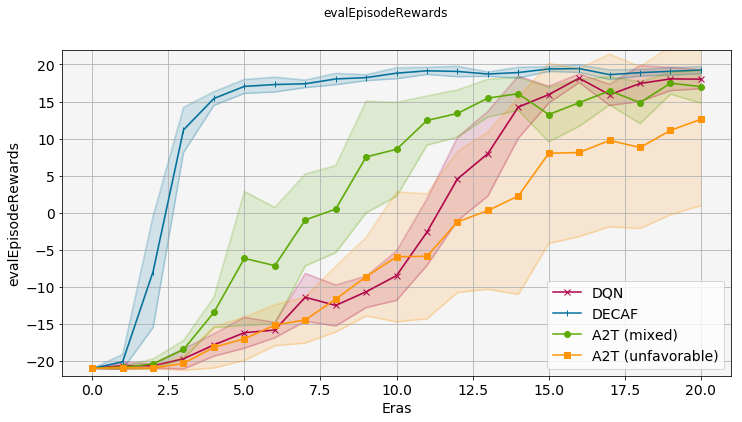

In [4]:
#### EXPERIMENT 1 ###
algo_info = {
    'DQN' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/DQN/DQN'),
    'DECAF' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/A2Tsmall/DECAF'),
    'A2T (mixed)' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/A2Tsmall/A2Tmixed'),
    'A2T (unfavorable)' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/A2Tsmall/A2Tunfavorable')
}

key_factors = [
    'evalEpisodeRewards',
]

plot_algos(algo_info, key_factors, only_summary=True)

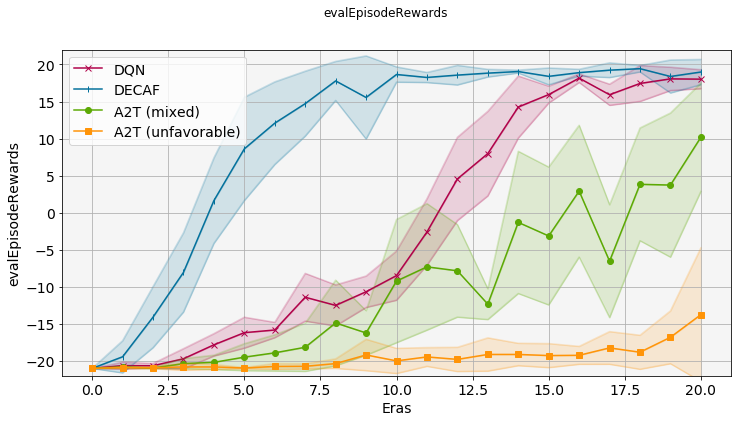

In [5]:
#### EXPERIMENT 2 ###
algo_info = {
    'DQN' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/DQN/DQN'),
    'DECAF' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/A2TBig/DECAF'),
    'A2T (mixed)' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/A2TBig/A2Tmixed'),
    'A2T (unfavorable)' : 
        Path('/Users/ruben/playground/pub_DECAF/experiments/Atari/Pong/A2Tbig/A2Tunfavorable')
}

key_factors = [
    'evalEpisodeRewards',
]

plot_algos(algo_info, key_factors, only_summary=True)

In [6]:
import gym
games = ['Pong-v0', 'SpaceInvaders-v0', 'Qbert-v0', 'Pooyan-v0']
for game in games:
    env = gym.make(game)
    print(game)
    print(env.observation_space, env.action_space, env.unwrapped.get_action_meanings())

Pong-v0
Box(210, 160, 3) Discrete(6) ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
SpaceInvaders-v0
Box(210, 160, 3) Discrete(6) ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Qbert-v0
Box(210, 160, 3) Discrete(6) ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN']
Pooyan-v0
Box(250, 160, 3) Discrete(6) ['NOOP', 'FIRE', 'UP', 'DOWN', 'UPFIRE', 'DOWNFIRE']
